import zipfile
with zipfile.ZipFile('custom.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamese-neural-network-with-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [1]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
path = './custom/full'

In [98]:
data = pd.DataFrame()

folders = os.listdir('./custom/full')
folders.sort()
folders = folders[:2]
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x]):
            if y != z:
                data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '/' + z, 0]])
                
for x in tqdm(range(0,len(folders),2)):
    for y in os.listdir(path + '/' + folders[x]):
        for z in os.listdir(path + '/' + folders[x] + '_forg'):
            data = data.append([[str(folders[x]) + '/' + y, str(folders[x]) + '_forg' + '/' + z, 1]])

data.to_csv('./custom/data.csv',index=False)
data.head(10)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,0,1,2
0,001/001_07.png,001/001_13.png,0
0,001/001_07.png,001/001_19.png,0
0,001/001_07.png,001/001_15.png,0
0,001/001_07.png,001/001_05.png,0
0,001/001_07.png,001/001_16.png,0
0,001/001_07.png,001/001_06.png,0
0,001/001_07.png,001/001_21.png,0
0,001/001_07.png,001/001_20.png,0
0,001/001_07.png,001/001_02.png,0
0,001/001_07.png,001/001_12.png,0


### Additional Utility Functions 

In [99]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Statified Split

In [100]:
data = pd.read_csv('./custom/data.csv').sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1]],data.iloc[:,[2]],test_size=0.1,stratify=data.iloc[:,2])

In [101]:
pd.concat([X_train,y_train],axis=1).to_csv('./custom/train_data.csv',index=False)
pd.concat([X_test,y_test],axis=1).to_csv('./custom/test_data.csv',index=False)

In [103]:
class Config():
    data_dir = "./model"
    train_batch_size = 32
    train_number_epochs = 100

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [104]:
data_dir = "./custom/full"
training_csv = "./custom/train_data.csv"
testing_csv = "./custom/test_data.csv"

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [105]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        #print(image1_path,image2_path)
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [106]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,data_dir,
                                        transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
                                       )

In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
print(example_batch[0].size())
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

torch.Size([8, 3, 224, 224])


## Siamese Network Definition

In [111]:
class SiameseNetwork(nn.Module):
    def __init__(self,resnet):
        super(SiameseNetwork, self).__init__()

        self.resnet = resnet
        fc_outputs = resnet.fc.out_features
        self.fc1 = nn.Sequential(
            #nn.Linear(fc_outputs, 1024),
            #nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            #nn.Linear(1024, 128),
            nn.Linear(fc_outputs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128,64))
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.resnet(x)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

### Loss Function

In [112]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        #loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        #loss_contrastive = torch.sum(loss_contrastive) / 2.0 / output1.size()[0]
        return loss_contrastive

### Plot Loss

In [113]:
def plot_loss(train_loss):
    plt.plot(train_loss, label="train loss")
    plt.legend()

### Train the Model

In [114]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [115]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [116]:
def train(net,criterion):
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i %100 == 0 :
                print("Epoch number {}\n Current loss {}\n Learning Rate {}\n".format(epoch,loss_contrastive.item(),optimizer.param_groups[0]['lr']))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        
        #if scheduler!=None:
            #scheduler.step()
    
    return net,loss_history

### Model 1 - Accuracy - 50

In [117]:
#resnet = torchvision.models.resnet50(pretrained=True)
#resnet = torch.hub.load('./model', 'resnet50', pretrained=True)

resnet = torchvision.models.resnet50(pretrained=False)
resnet.load_state_dict(torch.load('./model/resnet50-0676ba61.pth'))
for param in resnet.parameters():
    param.requires_grad = False

In [118]:
# Declare Siamese Network
net1 = SiameseNetwork(resnet).cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.Adam(net1.parameters(), lr=1e-7, eps=1e-8, weight_decay=0.0005) #RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model1,loss_history1 = train(net1,criterion)
torch.save(model1.state_dict(), "./model/model1.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.4791247248649597
 Learning Rate 1e-07

Epoch number 1
 Current loss 1.2996938228607178
 Learning Rate 1e-07

Epoch number 2
 Current loss 1.26585853099823
 Learning Rate 1e-07

Epoch number 3
 Current loss 2.054194688796997
 Learning Rate 1e-07

Epoch number 4
 Current loss 1.8013428449630737
 Learning Rate 1e-07

Epoch number 5
 Current loss 2.3526506423950195
 Learning Rate 1e-07

Epoch number 6
 Current loss 2.2563140392303467
 Learning Rate 1e-07

Epoch number 7
 Current loss 1.063189148902893
 Learning Rate 1e-07

Epoch number 8
 Current loss 0.8614131212234497
 Learning Rate 1e-07

Epoch number 9
 Current loss 1.2393648624420166
 Learning Rate 1e-07

Epoch number 10
 Current loss 1.9393587112426758
 Learning Rate 1e-07

Epoch number 11
 Current loss 1.0270051956176758
 Learning Rate 1e-07

Epoch number 12
 Current loss 1.4660413265228271
 Learning Rate 1e-07

Epoch number 13
 Current loss 1.6930186748504639
 Learning Rate 1e-07

Epoch number 14
 Cur

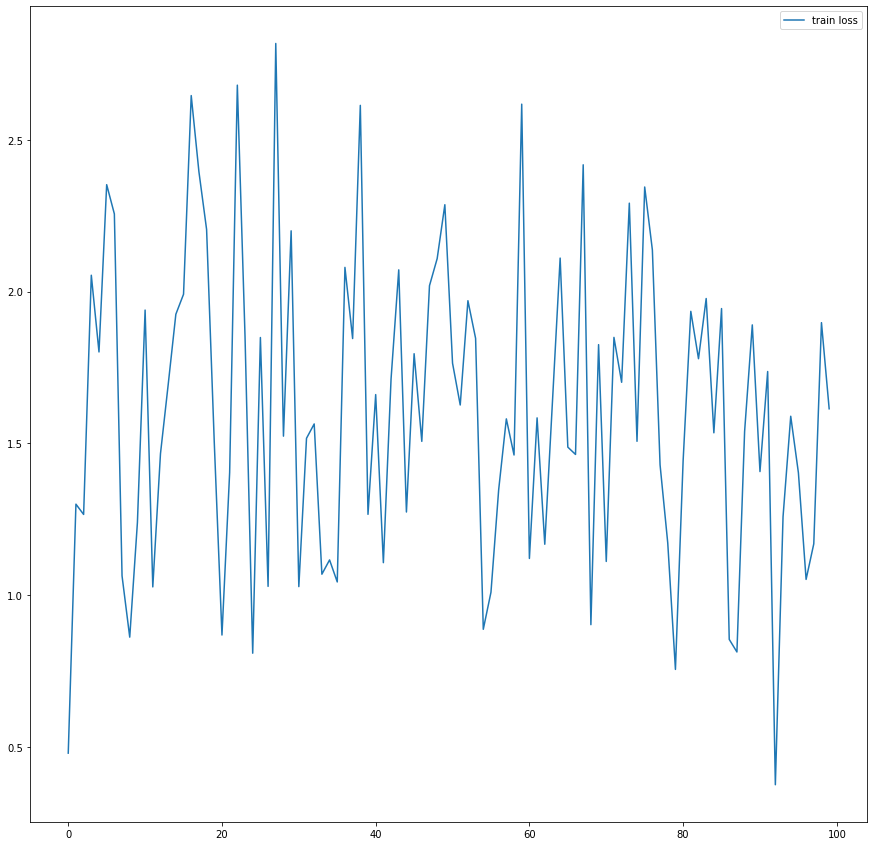

In [120]:
plot_loss(loss_history1)

### No. Of Trainable Parameters

In [121]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model1)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| fc1.0.weight |   128000   |
|  fc1.0.bias  |    128     |
| fc1.2.weight |    8192    |
|  fc1.2.bias  |     64     |
+--------------+------------+
Total Trainable Params: 136384


136384

### Testing

In [122]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=data_dir,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

### Prediction Model 1

In [123]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork(resnet).to(device)
model.load_state_dict(torch.load("./model/model1.pt"))

<All keys matched successfully>

In [124]:
# Print the sample outputs to view its dissimilarity
pos = 0
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    
    if eucledian_distance.item() <= 0.4:
        pred = 0.0
    else:
        pred = 1.0
        
    if pred == label.item():
        pos+=1
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
        
accuracy = pos/len(test_dataloader)
print('Accuracy : ',accuracy)

Accuracy :  0.7466666666666667
